In [ ]:
#pip install PySPG

In [1]:
# following tutorial at
# https://gsas-ii.readthedocs.io/en/latest/GSASIIscriptable.html#peak-fitting

In [2]:
import os,sys
import matplotlib.pyplot as plt
#import pandas as pd  # AC got a 'no module named pandas' error.  Do we need it?
import numpy as np
import math
import csv

# Eventually we'll have to find a common pathway, for now just change if this is commented out.
#sys.path.insert(0,'/Users/dtn1/gsas2full/GSASII/') # needed to "find" GSAS-II modules
sys.path.insert(0,'/Users/creuzige/gsas2full/envs/gsas2pkg/GSASII/') # needed to "find" GSAS-II modules

import GSASIIscriptable as G2sc

GSAS-II binary directory: /Users/creuzige/gsas2full/envs/gsas2pkg/GSASII/bindist
7 values read from config file /Users/creuzige/gsas2full/envs/gsas2pkg/GSASII/config.py


In [3]:
ScriptDirectory=os.getcwd()
GitLabDirectory=os.path.dirname(os.getcwd())
ExampleDataDirectory=os.path.join(GitLabDirectory,"ExampleData")
SaveDataDirectory=os.path.join(GitLabDirectory,"SaveData")

In [4]:
GitLabDirectory

'/Users/creuzige/Documents/NIST_Research/GitLab/austenitecalculator'

In [5]:

datadir = os.path.expanduser(ExampleDataDirectory)
SaveDir= os.path.expanduser(SaveDataDirectory)
DataPathWrap = lambda fil: os.path.join(datadir,fil)
SaveWrap = lambda fil: os.path.join(SaveDir,fil)
gpx = G2sc.G2Project(newgpx=SaveWrap('pkfit.gpx'))
hist = gpx.add_powder_histogram(DataPathWrap('Gonio_BB-HD-Cu_Gallipix3d[30-120]_New_Control_proper power.xrdml'),
                                DataPathWrap('TestCalibration.instprm'), # need to get a 
                                fmthint='Panalytical xrdml (xml)', databank=1, instbank=1)

/Users/creuzige/Documents/NIST_Research/GitLab/austenitecalculator/ExampleData/Gonio_BB-HD-Cu_Gallipix3d[30-120]_New_Control_proper power.xrdml block # 1 read by Reader Panalytical xrdml (xml)
Instrument parameters read: /Users/creuzige/Documents/NIST_Research/GitLab/austenitecalculator/ExampleData/TestCalibration.instprm (G2 fmt) bank 1


In [6]:
# Exploring the data structure.
# For more details see the developers documentation 
# https://gsas-ii.readthedocs.io/en/latest/index.html

In [7]:
#hist.data['data'][0]['hId']
#hist.data['Comments']
#hist['data']['hId'].data

In [8]:
#len(hist.data['data']) # 3 objects

#hist.data['data'][0] # dict: with some kind of meta-info?
#hist.data['data'][1] # np.array: see below
#hist.data['data'][2] # string: file name

# From: https://gsas-ii.readthedocs.io/en/latest/GSASIIobj.html?highlight=Powder%20Diffraction%20Tree#powder-diffraction-tree-items
    
    Data 		

(list) The data consist of a list of 6 np.arrays containing in order:

    the x-postions (two-theta in degrees),
    the intensity values (Yobs),
    the weights for each Yobs value
    the computed intensity values (Ycalc)
    the background values
    Yobs-Ycalc


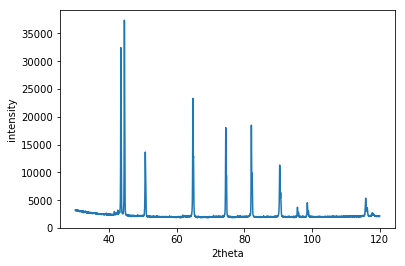

In [9]:
plt.plot(hist.data['data'][1][0], hist.data['data'][1][1])
plt.xlabel("2theta")
plt.ylabel("intensity")
plt.show()


## Add phases to the project

In [10]:
PhaseAustenite = gpx.add_phase(DataPathWrap("austenite-Duplex.cif"),
         phasename="Austenite",fmthint='CIF')

PhaseFerrite = gpx.add_phase(DataPathWrap("ferrite-Duplex.cif"),
         phasename="Ferrite",fmthint='CIF')

/Users/creuzige/Documents/NIST_Research/GitLab/austenitecalculator/ExampleData/austenite-Duplex.cif read by Reader CIF
gpx file saved as /Users/creuzige/Documents/NIST_Research/GitLab/austenitecalculator/SaveData/pkfit.gpx
/Users/creuzige/Documents/NIST_Research/GitLab/austenitecalculator/ExampleData/ferrite-Duplex.cif read by Reader CIF
gpx file saved as /Users/creuzige/Documents/NIST_Research/GitLab/austenitecalculator/SaveData/pkfit.gpx


In [11]:
## Guess locations for peaks based on lattice parameter

In [12]:
# Read the lattice parameter 
a0_Austenite=PhaseAustenite.data['General']['Cell'][1]
a0_Ferrite=PhaseFerrite.data['General']['Cell'][1]

In [13]:
# Find the ka1 wavelength
# hist.data['Comments']

Ka1_wavelength=float([s for s in hist.data['Comments'] if s.startswith('Ka1')][0].split('=')[1])

# Hardcode for testing
#Ka1_wavelength=2.29092 # Cr wavelength for testing

# Calculate locations of peaks from .cif file



## Bragg diffraction
n * lambda=2 * d * sin(theta)

In [14]:
#hardcoding HKL lists for now, likely better ways to do this later...
HKL_BCC=[[1,1,0],[2,0,0],[2,1,1],[2,2,0],[3,1,0],[2,2,2],[3,2,1],[4,1,1]]
HKL_FCC=[[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0],[3,3,1],[4,2,0],[4,2,2]]

In [15]:
#for hkl in HKL_BCC:
#    d=(a0_Ferrite/ math.sqrt(hkl[0]*hkl[0]+hkl[1]*hkl[1]+hkl[2]*hkl[2]))   
    
d_BCC=[a0_Ferrite/ math.sqrt(hkl[0]*hkl[0]+hkl[1]*hkl[1]+hkl[2]*hkl[2]) for hkl in HKL_BCC]
SinTheta_BCC=[1*Ka1_wavelength/(2*d) for d in d_BCC]

d_FCC=[a0_Austenite/ math.sqrt(hkl[0]*hkl[0]+hkl[1]*hkl[1]+hkl[2]*hkl[2]) for hkl in HKL_FCC]
SinTheta_FCC=[1*Ka1_wavelength/(2*d) for d in d_FCC]

In [16]:
# Create a list of 2Theta values from the dspacing and wavelength. Mark any non-physical values with np.nan
TwoTheta_BCC=[np.nan]*len(SinTheta_BCC)
for i,value in enumerate(SinTheta_BCC):
    #print(value)
    try:
        TwoTheta_BCC[i]=(2*math.degrees(math.asin(value)))
    except:
        TwoTheta_BCC[i]=(np.nan)
#print(TwoTheta_BCC)
#print(HKL_BCC)       
        
TwoTheta_FCC=[np.nan]*len(SinTheta_FCC)
for i,value in enumerate(SinTheta_FCC):
    #print(value)
    try:
        TwoTheta_FCC[i]=(2*math.degrees(math.asin(value)))
    except:
        TwoTheta_FCC[i]=(np.nan)
#print(TwoTheta_FCC)
#print(HKL_FCC)



In [17]:
# Create a list of TwoTheta in the data range
#print(max(hist.data['data'][1][0]))

TwoThetaInRange_BCC=[np.nan if i > max(hist.data['data'][1][0]) else i for i in TwoTheta_BCC]
TwoThetaInRange_BCC=[np.nan if i < min(hist.data['data'][1][0]) else i for i in TwoThetaInRange_BCC]

TwoThetaInRange_FCC=[np.nan if i > max(hist.data['data'][1][0]) else i for i in TwoTheta_FCC]
TwoThetaInRange_FCC=[np.nan if i < min(hist.data['data'][1][0]) else i for i in TwoThetaInRange_FCC]


#print(TwoTheta_FCC)
#print(TwoThetaInRange_FCC)



In [18]:
PeaksList=[]
PeaksList = np.array(TwoThetaInRange_BCC)[~np.isnan(np.array(TwoThetaInRange_BCC))]
PeaksList = np.concatenate((PeaksList,
                           np.array(TwoThetaInRange_FCC)[~np.isnan(np.array(TwoThetaInRange_FCC))]),
                           axis=0)
PeaksList=list(PeaksList)
# Don't sort, it actually makes keeping track of the different items harder...
# PeaksList.sort()

In [19]:
print(PeaksList)

[44.25400504560493, 64.37327635613593, 81.44495562762073, 97.75788776253452, 114.75469634990064, 43.20474072132704, 50.31626972156883, 73.91288231727276, 89.65561531281976, 94.83876690428124, 116.47470981868203]


In [20]:
#CIF is slightly off, kludge for now...
# Likely need to refine, adjust lattice parameters and start over again with peaks with non-negative intensities
# Or fix the negative intensities...
PeaksList=[x+0.5 for x in PeaksList]

In [21]:
# reset the peak list in case of errors...
hist.Peaks['peaks']=[]

## Start Fitting

In [22]:
hist.set_refinements({'Background': {"no. coeffs": 5,'type': 'chebyschev-1', 'refine': True}})
hist.refine_peaks()

Number of function calls: 7 Number of observations: 3140 Number of parameters: 5
fitpeak time =    0.029s,    0.010s/cycle
Rwp =   34.25%, chi**2 =       940533, reduced chi**2 = 300.01
Background coefficients for chebyschev-1 function
value:   2358.63862  -324.96757   298.54077  -102.21858    74.60512
esd  :     18.76352    30.97063    29.62959    24.74965    24.56130


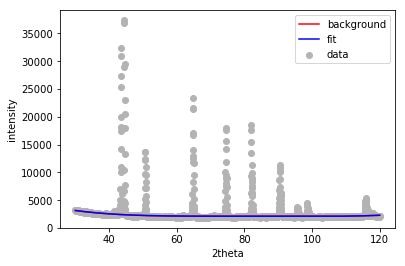

In [23]:
plt.scatter(hist.data['data'][1][0], hist.data['data'][1][1], label='data', color='0.7')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][4], label='background', color='r')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][3], label='fit', color='b')
plt.xlabel("2theta")
plt.ylabel("intensity")
plt.legend()
plt.show()

## Add a few peaks to the list

- It seems like the peak positions are slightly off from the .cif file (about 0.4°)
- This results in negative intensities for some of the higher peaks
- Maybe look for maxima?  Or a series of fit sequences?
- Error check negative peaks?

In [24]:
#for peak in PeaksList[0:5]:
for peak in PeaksList:
    hist.add_peak(1, ttheta=peak)




In [25]:
# Need to use this order, otherwise fitting gets unstable
hist.set_peakFlags(area=True)
hist.refine_peaks()

# Resetting the value doesn't seem to work...
# for i,value in enumerate(hist.Peaks['peaks']):
#     print(value[2])
#     if value[2]<0:
#         print(hist.Peaks['peaks'][i][2],-value[2])
#         hist.Peaks['peaks'][i][2]=-value[2]
        
# hist.set_peakFlags(pos=True)
# hist.refine_peaks()
        
hist.set_peakFlags(pos=True,area=True)
hist.refine_peaks()
hist.set_peakFlags(pos=True,area=True,sig=True)
hist.refine_peaks()

Number of function calls: 3 Number of observations: 3140 Number of parameters: 16
fitpeak time =    0.066s,    0.066s/cycle
Rwp =   28.95%, chi**2 =       672146, reduced chi**2 = 215.16
Background coefficients for chebyschev-1 function
value:   2311.08818  -323.81198   342.87760  -107.65019    48.45557
esd  :     16.57061    27.42416    26.27250    21.77779    21.35645
Peak coefficients:
                pos       esd       int       esd       sig       esd       gam       esd      bins  
 Peak1   :  44.75401              9125.1    2013.7    18.465               4.135               4.35
 Peak2   :  64.87328             74308.4    3907.9    21.509               5.973               5.03
 Peak3   :  81.94496             62278.8    3760.9    24.894               7.913               5.75
 Peak4   :  98.25789              5673.8    2404.5    29.372              10.331               6.67
 Peak5   : 115.25470              6928.1    2832.1    36.560              13.918               8.04
 Peak6

In [26]:
#hist.set_peakFlags(area=True,pos=True,sig=True)

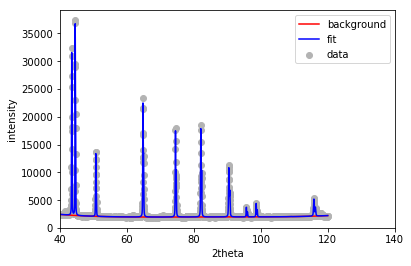

In [27]:

plt.xlim([40,140])

plt.scatter(hist.data['data'][1][0], hist.data['data'][1][1], label='data', color='0.7')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][4], label='background', color='r')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][3], label='fit', color='b')
plt.xlabel("2theta")
plt.ylabel("intensity")
plt.legend()
plt.show()

In [ ]:
type(hist)

In [ ]:
hist.Peaks['peaks'][0][0]

In [ ]:
for i,value in enumerate(hist.Peaks['peaks']):
    print(value[2])
    if value[2]<0:
        print(hist.Peaks['peaks'][i][2],-value[2])
        hist.Peaks['peaks'][i][2]=-value[2]
# hist.PeakList[0][0]=0
print(hist.PeakList)

In [ ]:
for i,value in enumerate(hist.PeakList):
    print(value[1])
    if value[1]<0:
        print(hist.PeakList[i][1],-value[1])
        hist.PeakList[i][1]=-value[1]
hist.PeakList[0][0]=0
print(hist.PeakList)

In [ ]:
# Not working properly yet...

In [ ]:
# print('peak positions: ',[i[0] for i in hist.PeakList])
# for i in range(len(hist.Peaks['peaks'])):
#     print('peak',i,'pos=',hist.Peaks['peaks'][i][0],'sig=',hist.Peaks['sigDict']['pos'+str(i)])


In [ ]:
# for peak in PeaksList:
#     hist.add_peak(1, ttheta=peak)
# hist.set_peakFlags(area=True,pos=True,sig=True)


In [ ]:
## TODO: ADD pattern simulation, extract intensities from that?

In [ ]:
### Have not edited below this for austenite calculator

In [ ]:
dlist=[2.0923, 2.0923-0.05, 2.0923+0.05]
TOFlist=[]
for i in dlist:
    print(TOF_calc(i,16324.50,6.86,0.00))
    TOFlist.append(TOF_calc(i,16324.50,6.86,0.00))

In [ ]:


plt.xlim(TOFlist[1],TOFlist[2])
plt.plot(hist.data['data'][1][0], hist.data['data'][1][1])
plt.show()

In [ ]:
def OutputData(hist, append, Tick, LowLimit, HighLimit):
    # plot fit and difference
    plt.figure(figsize=[10,8])
    plt.scatter(hist.data['data'][1][0], hist.data['data'][1][1],color='k',label='Data')
    plt.plot(hist.data['data'][1][0], hist.data['data'][1][3],color='b',label='Computed Intensity')
    plt.plot(hist.data['data'][1][0], hist.data['data'][1][5],'-o',color='g',label='Difference')
    # vertical line for place of intial guess
    plt.vlines(Tick,0,plt.gca().get_ylim()[0]*0.5)
    # horizontal line to benchmark difference plot
    plt.hlines(0,plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],'0.7')
    plt.xlim(LowLimit, HighLimit)
    plt.legend()
    # option to view on screen
    #plt.show()
    # option to save the plot
    plt.savefig("GSASPeakFit-"+append+".png", dpi=300)

    keys = hist.Peaks['sigDict'].keys()
    #print(keys)
    with open("GSASPeakFit-"+append+".csv",'a') as fd:
        wr=csv.writer(fd)
        dwr=csv.DictWriter(fd, keys)

        wr.writerow(['# TOF position (pos)', 'Area (int)','Alpha (alp)','Beta (bet)','Sigma (sig)','Gamma (gam)'])
        wr.writerow(['# Peak Parameter List'])
        wr.writerow(['# Peak Parameter Flags'])
        wr.writerow(hist.Peaks['peaks'][0][0::2])
        wr.writerow(hist.Peaks['peaks'][0][1::2])
        wr.writerow(["########################"])
        wr.writerow(['# Background Values'])
        wr.writerow(hist['Background'][0][3:])
        wr.writerow(["########################"])
        wr.writerow(['# SigDict Keys'])
        wr.writerow(['# SigDict Values'])
        dwr.writeheader()
        dwr.writerows([hist.Peaks['sigDict']])
        wr.writerow(["########################"])
        wr.writerow(['# Covariance Matrix'])
        wr.writerows(np.array(hist['Peak Fit Result'][1]))
        wr.writerow(["########################"])        
        wr.writerow(['# Correlation Matrix'])
        wr.writerows(np.corrcoef(hist['Peak Fit Result'][1]))
        wr.writerow(["########################"])        
        wr.writerow(['# Reduced ChiSq (GOF)'])
        wr.writerow([hist.data['Peak Fit Rvals']['GOF']])
        wr.writerow(["########################"])   
        wr.writerow(['# Dspacing (1 term) -/+ (3 terms)'])
        try:
            d=Dspace_calc(hist.Peaks['peaks'][0][0],16324.50,6.86,0.00)
            d_minus=Dspace_calc(hist.Peaks['peaks'][0][0]-hist.Peaks['sigDict']['pos0'],16324.50,6.86,0.00)
            d_plus=Dspace_calc(hist.Peaks['peaks'][0][0]+hist.Peaks['sigDict']['pos0'],16324.50,6.86,0.00)
            wr.writerow([d,d_minus,d_plus])
            wr.writerow([d,d-d_minus,d_plus-d])
        except:
            wr.writerow([Dspace_calc(hist.Peaks['peaks'][0][0],16324.50,6.86,0.00)])             
    fd.close()

In [ ]:
for i in range(len(hist.Peaks['peaks'])):
    print(i)

In [ ]:
hist['Background'][0][3:]

In [ ]:
hist.Peaks['peaks'][0][0::2]

In [ ]:
hist.Peaks['sigDict']

In [ ]:
#OutputData(hist, "", TOFlist[0],TOFlist[1],TOFlist[2])
# Doesn't work well prior to fitting

# Sequence 1, following Rawplot method

In [ ]:
# Define peaks to fit
#Limit is between the 422 and 333 peaks

hist.set_refinements({'Limits': [TOFlist[1],TOFlist[2]],  
      'Background': {"no. coeffs": 2,'type': 'chebyschev-1', 'refine': True}
                     })
# TOF data isn't listed right now.
peak1 = hist.add_peak(1, dspace=2.0923)




In [ ]:
# Following Rawplot method (seq1)

#area alone doesn't work well, since there is no positions
hist.set_peakFlags(area=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step1-Area",TOFlist[0],TOFlist[1],TOFlist[2])

#
hist.set_peakFlags(area=0,pos=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step2-Pos",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(area=True,pos=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step3-Pos-Area",TOFlist[0],TOFlist[1],TOFlist[2])

#These don't change sigma and gamma, but they do change alpha and beta...

hist.set_peakFlags(area=True, pos=0, sig=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step4-Area-Sig",TOFlist[0],TOFlist[1],TOFlist[2])

#hist.set_peakFlags(area=True, pos=True, gam=True)
#hist.refine_peaks()

hist.set_peakFlags(area=0, pos=0, sig=0, gam=True)
hist.refine_peaks()
OutputData(hist, "Seq1-Step5-Gam",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(area=True, pos=True, sig=True, gam=0)
hist.refine_peaks()
OutputData(hist, "Seq1-Step6-Area-Pos-Sig",TOFlist[0],TOFlist[1],TOFlist[2])



# hist.set_peakFlags(area=True, pos=True,alp=True,bet=True, sig=True, gam=True)
# hist.refine_peaks()
# OutputData(hist, "Seq-Area-Pos-Sig-Gam-Alp-Bet",TOFlist[0],TOFlist[1],TOFlist[2])


# Sequence 2 (Single background; alpha and beta refined, not gamma)

In [ ]:
# Define peaks to fit
#Limit is between the 422 and 333 peaks

hist.set_refinements({'Limits': [TOFlist[1],TOFlist[2]],  
      'Background': {"no. coeffs": 1,'type': 'chebyschev-1', 'refine': True}
                     })
# TOF data isn't listed right now.
peak1 = hist.add_peak(1, dspace=2.0923)




In [ ]:
# Following Rawplot method (seq2)

#area alone doesn't work well, since there is no positions
hist.set_peakFlags(area=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step1-Area",TOFlist[0],TOFlist[1],TOFlist[2])

#
hist.set_peakFlags(area=0,pos=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step2-Pos",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(area=True,pos=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step3-Pos-Area",TOFlist[0],TOFlist[1],TOFlist[2])

#These don't change sigma and gamma, but they do change alpha and beta...

hist.set_peakFlags(area=True, pos=0, sig=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step4-Area-Sig",TOFlist[0],TOFlist[1],TOFlist[2])

#hist.set_peakFlags(area=True, pos=True, gam=True)
#hist.refine_peaks()

hist.set_peakFlags(area=0, pos=0, sig=0, alp=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step5-Alp",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(alp=0, bet=True)
hist.refine_peaks()
OutputData(hist, "Seq2-Step6-Bet",TOFlist[0],TOFlist[1],TOFlist[2])

hist.set_peakFlags(area=True, pos=True, sig=True, bet=0)
hist.refine_peaks()
OutputData(hist, "Seq2-Step7-Area-Pos-Sig",TOFlist[0],TOFlist[1],TOFlist[2])



# hist.set_peakFlags(area=True, pos=True,alp=True,bet=True, sig=True, gam=True)
# hist.refine_peaks()
# OutputData(hist, "Seq-Area-Pos-Sig-Gam-Alp-Bet",TOFlist[0],TOFlist[1],TOFlist[2])


In [ ]:
gpx.get_Covariance(['0:0:Back;0','0:0:Back;1','0:0:pos0','0:0:int0','sig0'])

In [ ]:
hist.keys()

In [ ]:
hist['Background']

In [ ]:
hist['Peak Fit Result'][1]

In [ ]:
np.corrcoef(hist['Peak Fit Result'][1])

# Nothing run below this

In [ ]:
hist.Peaks['sigDict']

In [ ]:
hist.data

In [ ]:
if 'C' in hist.data['Instrument Parameters'][0]['Type'][0]:
    print("hi")
else:
    print("low")

In [ ]:
hist.data['Peak Fit Rvals']['GOF']

In [ ]:
hist.set_peakFlags(area=True, pos=True, sig=True)
hist.refine_peaks()
hist.set_peakFlags(area=True, pos=True, gam=True)
hist.refine_peaks()
hist.set_peakFlags(area=True, pos=True, sig=True, gam=True)
hist.refine_peaks()

In [ ]:
print('peak positions: ',[i[0] for i in hist.PeakList])
for i in range(len(hist.Peaks['peaks'])):
    print('peak',i,'pos=',hist.Peaks['peaks'][i][0],'sig=',hist.Peaks['sigDict']['pos'+str(i)])


In [ ]:
hist.Peaks['sigDict']

In [ ]:
# fit peaks
plt.plot(hist.data['data'][1][0], hist.data['data'][1][3],label='Computed Intensity')
plt.xlim(11752.,40000.)
plt.show()

In [ ]:
# fit difference
plt.figure(figsize=[10,8])
plt.plot(hist.data['data'][1][0], hist.data['data'][1][1],color='k',label='Data')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][3],color='b',label='Computed Intensity')
plt.plot(hist.data['data'][1][0], hist.data['data'][1][5],color='g',label='Difference')
plt.xlim(11752.,40000.)
plt.legend()
plt.show()

In [ ]:
for i in range(len(hist.Peaks['peaks'])):
    print('peak',i)
    print('TOF pos=',hist.Peaks['peaks'][i][0],'sig=',hist.Peaks['sigDict']['pos'+str(i)])
    print('Dspace pos=', Dspace_calc(hist.Peaks['peaks'][i][0],16324.50,6.86,0.00),
          'sig (pos)=',Dspace_calc(hist.Peaks['peaks'][i][0]+hist.Peaks['sigDict']['pos'+str(i)],16324.50,6.86,0.00)-
          Dspace_calc(hist.Peaks['peaks'][i][0],16324.50,6.86,0.00),
          'sig (neg)=',Dspace_calc(hist.Peaks['peaks'][i][0],16324.50,6.86,0.00)-
          Dspace_calc(hist.Peaks['peaks'][i][0]-hist.Peaks['sigDict']['pos'+str(i)],16324.50,6.86,0.00))
    
    

In [ ]:
print(hist.Peaks)

## From GSASIIscriptable.py, lines 4007

        :returns: dict with two elements where item
          'peaks' is a list of peaks where each element is 
          [pos,pos-ref,area,area-ref,sig,sig-ref,gam,gam-ref], 
          where the -ref items are refinement flags and item
          'sigDict' is a dict with possible items 'Back;#', 
          'pos#', 'int#', 'sig#', 'gam#'
          
Fitting output lists:pos       esd       int       esd      alp     esd     bet     esd      sig       esd       gam       esd      bins

The fitting output values correspond to the column values

In [ ]:
#print(hist.Peaks)
HistDF=pd.DataFrame(hist.Peaks['peaks'], columns=['pos','pos-ref','area','area-ref','alph',
                                                  'alph-ref','bet','bet-ref','Sig','Sig-ref',
                                                  'Gam','gam-ref'])
print(HistDF)

In [ ]:
print(hist.Peaks['sigDict'])

In [ ]:
SigDF=pd.DataFrame(hist.Peaks['sigDict'])#, columns=['pos','pos-ref','area','area-ref','alph',
                                            #      'alph-ref','bet','bet-ref','Sig','Sig-ref',
                                            #      'Gam','gam-ref'])
print(SigDF)

In [ ]:
DataList=[]
for i in range(len(hist.Peaks['peaks'])):
    #print('peak',i)
    #print('TOF pos=',hist.Peaks['peaks'][i][0],'sig=',hist.Peaks['sigDict']['pos'+str(i)])
    DataList.append([i,hist.Peaks['peaks'][i][0],hist.Peaks['sigDict']['pos'+str(i)]])
#print(DataList)
ListDF=pd.DataFrame(DataList, columns=['Peak index','TOF Pos','TOF esd'])

#ListDF['Dspace Pos']=Dspace_calc(ListDF['TOF Pos'],16324.50,6.86,0.00)
ListDF['Dspace Pos']=ListDF.apply(lambda x: Dspace_calc(x['TOF Pos'],16324.50,6.86,0.00), axis=1)
ListDF['Dspace esd']=ListDF.apply(lambda x: Dspace_calc(x['TOF Pos']+x['TOF esd'],16324.50,6.86,0.00) - 
                                      Dspace_calc(x['TOF Pos'],16324.50,6.86,0.00), axis=1)
print(ListDF)
ListDF.to_csv('GSASPeakFit.csv')

In [ ]:
##  See further down on sequential refinements
# Sequential Refinement

# gpx.set_Controls('cycles',10)